# Analiza i prognozowanie inflacji w województwach Polski

## 1. Opis problemu

Inflacja, rozumiana jako wzrost ogólnego poziomu cen towarów i usług w gospodarce, to jeden z najważniejszych wskaźników makroekonomicznych. Ma ona bezpośredni wpływ na siłę nabywczą ludności, stabilność gospodarczą oraz decyzje inwestycyjne. Monitorowanie i prognozowanie inflacji na poziomie województw pozwala zrozumieć zróżnicowanie procesów gospodarczych w różnych regionach Polski, a także wspiera podejmowanie trafnych decyzji przez samorządy, przedsiębiorców oraz mieszkańców. Prognozy inflacji są wykorzystywane m.in. w planowaniu budżetów, indeksacji wynagrodzeń i świadczeń, a także w ocenie ryzyka inwestycyjnego. Aktualność i praktyczne znaczenie tego zagadnienia sprawiają, że analiza regionalnych wskaźników inflacji stanowi wartościowy przedmiot badań.

### Wyjaśnienie sposobu pomiaru inflacji w Banku Danych Lokalnych

Wskaźniki inflacji wykorzystane w niniejszej analizie pochodzą z Banku Danych Lokalnych GUS i zostały opracowane na podstawie przeciętnych cen producentów na rynku krajowym. Ceny skupu obejmują przeciętne roczne ceny płacone przez podmioty gospodarcze skupujące produkty rolne bezpośrednio od producentów rolnych. Podstawą do opracowania wskaźników cen towarów i usług są obserwacje cen reprezentantów, a prezentowane dane mają charakter szacunkowy.

## 2. Opis sposobu rozwiązania

W analizie wykorzystano kwartalne dane o wskaźnikach inflacji w poszczególnych województwach Polski z lat 2005–2024. Zbiór danych umożliwia analizę przestrzenno-czasową oraz przygotowanie prognoz na kolejne okresy. Zakres danych pozwala zidentyfikować trendy, sezonowość i anomalie w kształtowaniu się inflacji regionalnej.

Dane zostały poddane oczyszczeniu oraz transformacjom przygotowującym je do analizy szeregów czasowych. Eksploracyjna analiza danych objęła statystyki opisowe, analizę rozkładów, wykrywanie wartości odstających oraz identyfikację sezonowości. Do prognozowania kwartalnych wskaźników inflacji dla każdego województwa zastosowano model ARIMA, którego parametry zostały dobrane automatycznie na podstawie szeregów czasowych. Podział na zbiór treningowy (do 2022 roku) oraz testowy (2023–2024) pozwolił na ocenę jakości prognoz.

Wyniki zostały przedstawione w formie tabelarycznej oraz wizualnej (wykresy, mapa Polski), co umożliwia intuicyjne porównanie sytuacji w regionach oraz ocenę precyzji prognoz.

## 3. Kod zawierający obliczenia

Poniżej przedstawiono fragmenty kodu realizujące kolejne etapy analizy. Po każdym bloku kodu zamieszczono odpowiadające mu wykresy oraz – w przypadku analizy wartości odstających – opis procesu myślowego dotyczącego ich interpretacji i decyzji analitycznych.

---

### Wczytanie i przygotowanie danych

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error

In [2]:
# Ścieżka do pliku z danymi
data_path = "raw_data.csv"

# Wczytanie i wstępna obróbka danych
df = pd.read_csv(data_path, sep=';', encoding='utf-8', low_memory=False)

df.dropna(axis=1, how='all', inplace=True)
df.drop(columns=['Atrybut', 'Jednostka miary', 'Kod', 'Wskaźnik cen'], inplace=True, errors='ignore')
df = df[df['Rok'] != 2025]

df.rename(columns={'Nazwa': 'Wojewodztwo', 'Okresy': 'Okres'}, inplace=True)
df.sort_values(by=["Wojewodztwo", 'Rok', 'Okres'], inplace=True)
df.reset_index(drop=True, inplace=True)

df['Rok'] = df['Rok'].astype(int)

okres_mapping = {'1 kwartał': 'Q1', '2 kwartał': 'Q2', '3 kwartał': 'Q3', '4 kwartał': 'Q4'}
df['Okres'] = df['Okres'].map(okres_mapping)
df['Okres'] = pd.Categorical(df['Okres'], categories=['Q1', 'Q2', 'Q3', 'Q4'], ordered=True)

df['Wartosc'] = pd.to_numeric(df['Wartosc'].str.replace(',', '.'), errors='coerce')

df['Okres_czas'] = df['Rok'].astype(str) + df['Okres'].str.replace('Q', '-Q')
df['Okres_czas'] = pd.PeriodIndex(df['Okres_czas'], freq='Q')

df = df.sort_values(['Wojewodztwo', 'Okres_czas']).reset_index(drop=True)

df['Kwartal'] = df['Rok'].astype(str) + '-' + df['Okres'].astype(str)

---

### Eksploracyjna analiza danych

In [3]:
# Informacje o danych
print(df.info())

# Zakres lat i unikalne jednostki
print("\nZakres lat:", df['Rok'].min(), '-', df['Rok'].max())
print("Województwa:", df['Wojewodztwo'].unique())

# Statystyki opisowe dla inflacji
print("\nStatystyki opisowe dla inflacji:")
print(df['Wartosc'].describe())

print("\nStatystyki opisowe dla inflacji (grupowane według województw):")
print(df.groupby('Wojewodztwo')['Wartosc'].agg(['mean', 'std', 'min', 'max']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype        
---  ------       --------------  -----        
 0   Wojewodztwo  1280 non-null   object       
 1   Okres        1280 non-null   category     
 2   Rok          1280 non-null   int64        
 3   Wartosc      1280 non-null   float64      
 4   Okres_czas   1280 non-null   period[Q-DEC]
 5   Kwartal      1280 non-null   object       
dtypes: category(1), float64(1), int64(1), object(2), period[Q-DEC](1)
memory usage: 51.6+ KB
None

Zakres lat: 2005 - 2024
Województwa: ['DOLNOŚLĄSKIE' 'KUJAWSKO-POMORSKIE' 'LUBELSKIE' 'LUBUSKIE' 'MAZOWIECKIE'
 'MAŁOPOLSKIE' 'OPOLSKIE' 'PODKARPACKIE' 'PODLASKIE' 'POMORSKIE'
 'WARMIŃSKO-MAZURSKIE' 'WIELKOPOLSKIE' 'ZACHODNIOPOMORSKIE' 'ŁÓDZKIE'
 'ŚLĄSKIE' 'ŚWIĘTOKRZYSKIE']

Statystyki opisowe dla inflacji:
count    1280.000000
mean      100.835703
std         1.169597
min        99.000000
25%       100.100

---

#### Wykres: Inflacja w wybranym województwie w czasie

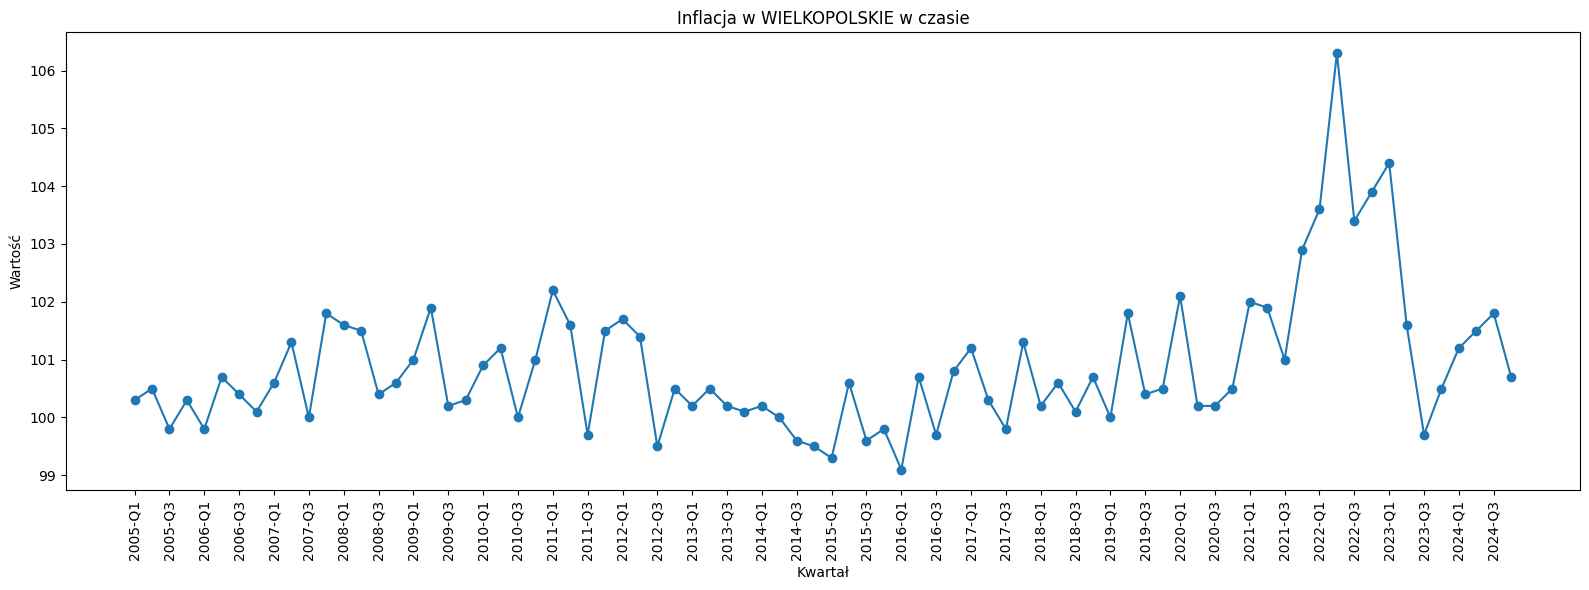

In [4]:
# Wykres: Inflacja w czasie dla wybranego województwa
woj = 'WIELKOPOLSKIE'
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df[df['Wojewodztwo'] == woj]['Kwartal'], df[df['Wojewodztwo'] == woj]['Wartosc'], marker='o')
ax.set_title(f'Inflacja w {woj} w czasie')
ax.set_xlabel('Kwartał')
ax.set_ylabel('Wartość')
xticks = ax.get_xticks()
ax.set_xticks(xticks[::2])
plt.setp(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

*Wizualizacja: Inflacja w województwie wielkopolskim w czasie.*

---

#### Wykres: Porównanie rozkładów inflacji w województwach (boxplot)

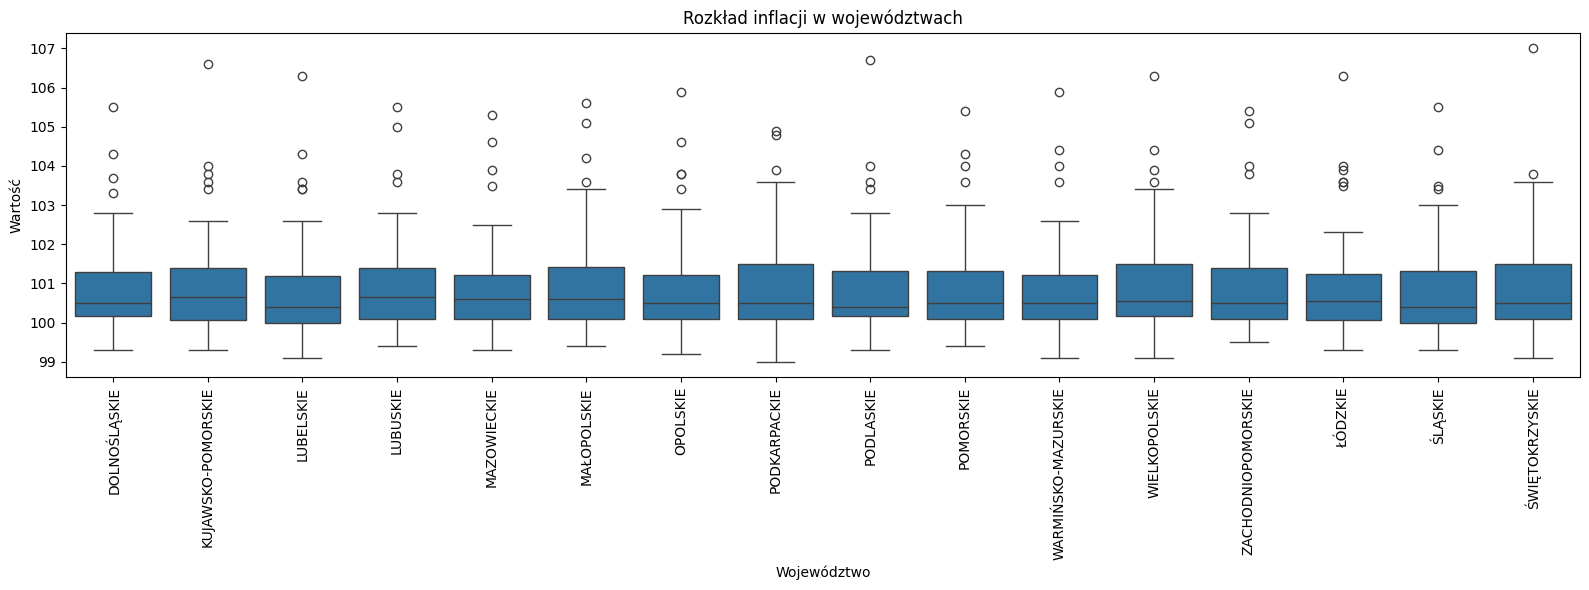

In [5]:
# Wykres: Porównanie rozkładów inflacji w województwach (boxplot)
plt.figure(figsize=(16,6))
sns.boxplot(data=df, x='Wojewodztwo', y='Wartosc')
plt.title('Rozkład inflacji w województwach')
plt.xlabel('Województwo')
plt.ylabel('Wartość')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

*Wizualizacja: Porównanie rozkładów inflacji w regionach – wartości odstające są zbliżone w większości województw.*

---

#### Identyfikacja i analiza wartości odstających

W procesie eksploracji danych pojawił się problem wartości odstających (outlierów). Wartości te mogą istotnie wpływać na wyniki modelowania szeregów czasowych, zwłaszcza w kontekście prognozowania. Przeprowadzono więc identyfikację wartości odstających dla każdego województwa osobno, korzystając z klasycznej reguły pudełkowej (1.5 x IQR).

**Proces myślowy:**
- Wartości odstające zostały potraktowane nie jako anomalia danych, lecz jako potencjalny efekt rzeczywistych, gwałtownych zmian cen wywołanych przez zjawiska o charakterze ogólnokrajowym (np. pandemia COVID-19).
- Zdecydowano się nie usuwać outlierów, ponieważ ich obecność odzwierciedla pełną dynamikę inflacji i pozwala modelowi ARIMA lepiej uchwycić ryzyko powtórzenia się podobnych sytuacji w przyszłości.
- Obserwacje odstające występowały w tym samym okresie we wszystkich województwach, co sugeruje, że nie były wynikiem błędów pomiarowych czy specyfiki regionalnej, lecz ogólnopolskich szoków gospodarczych.

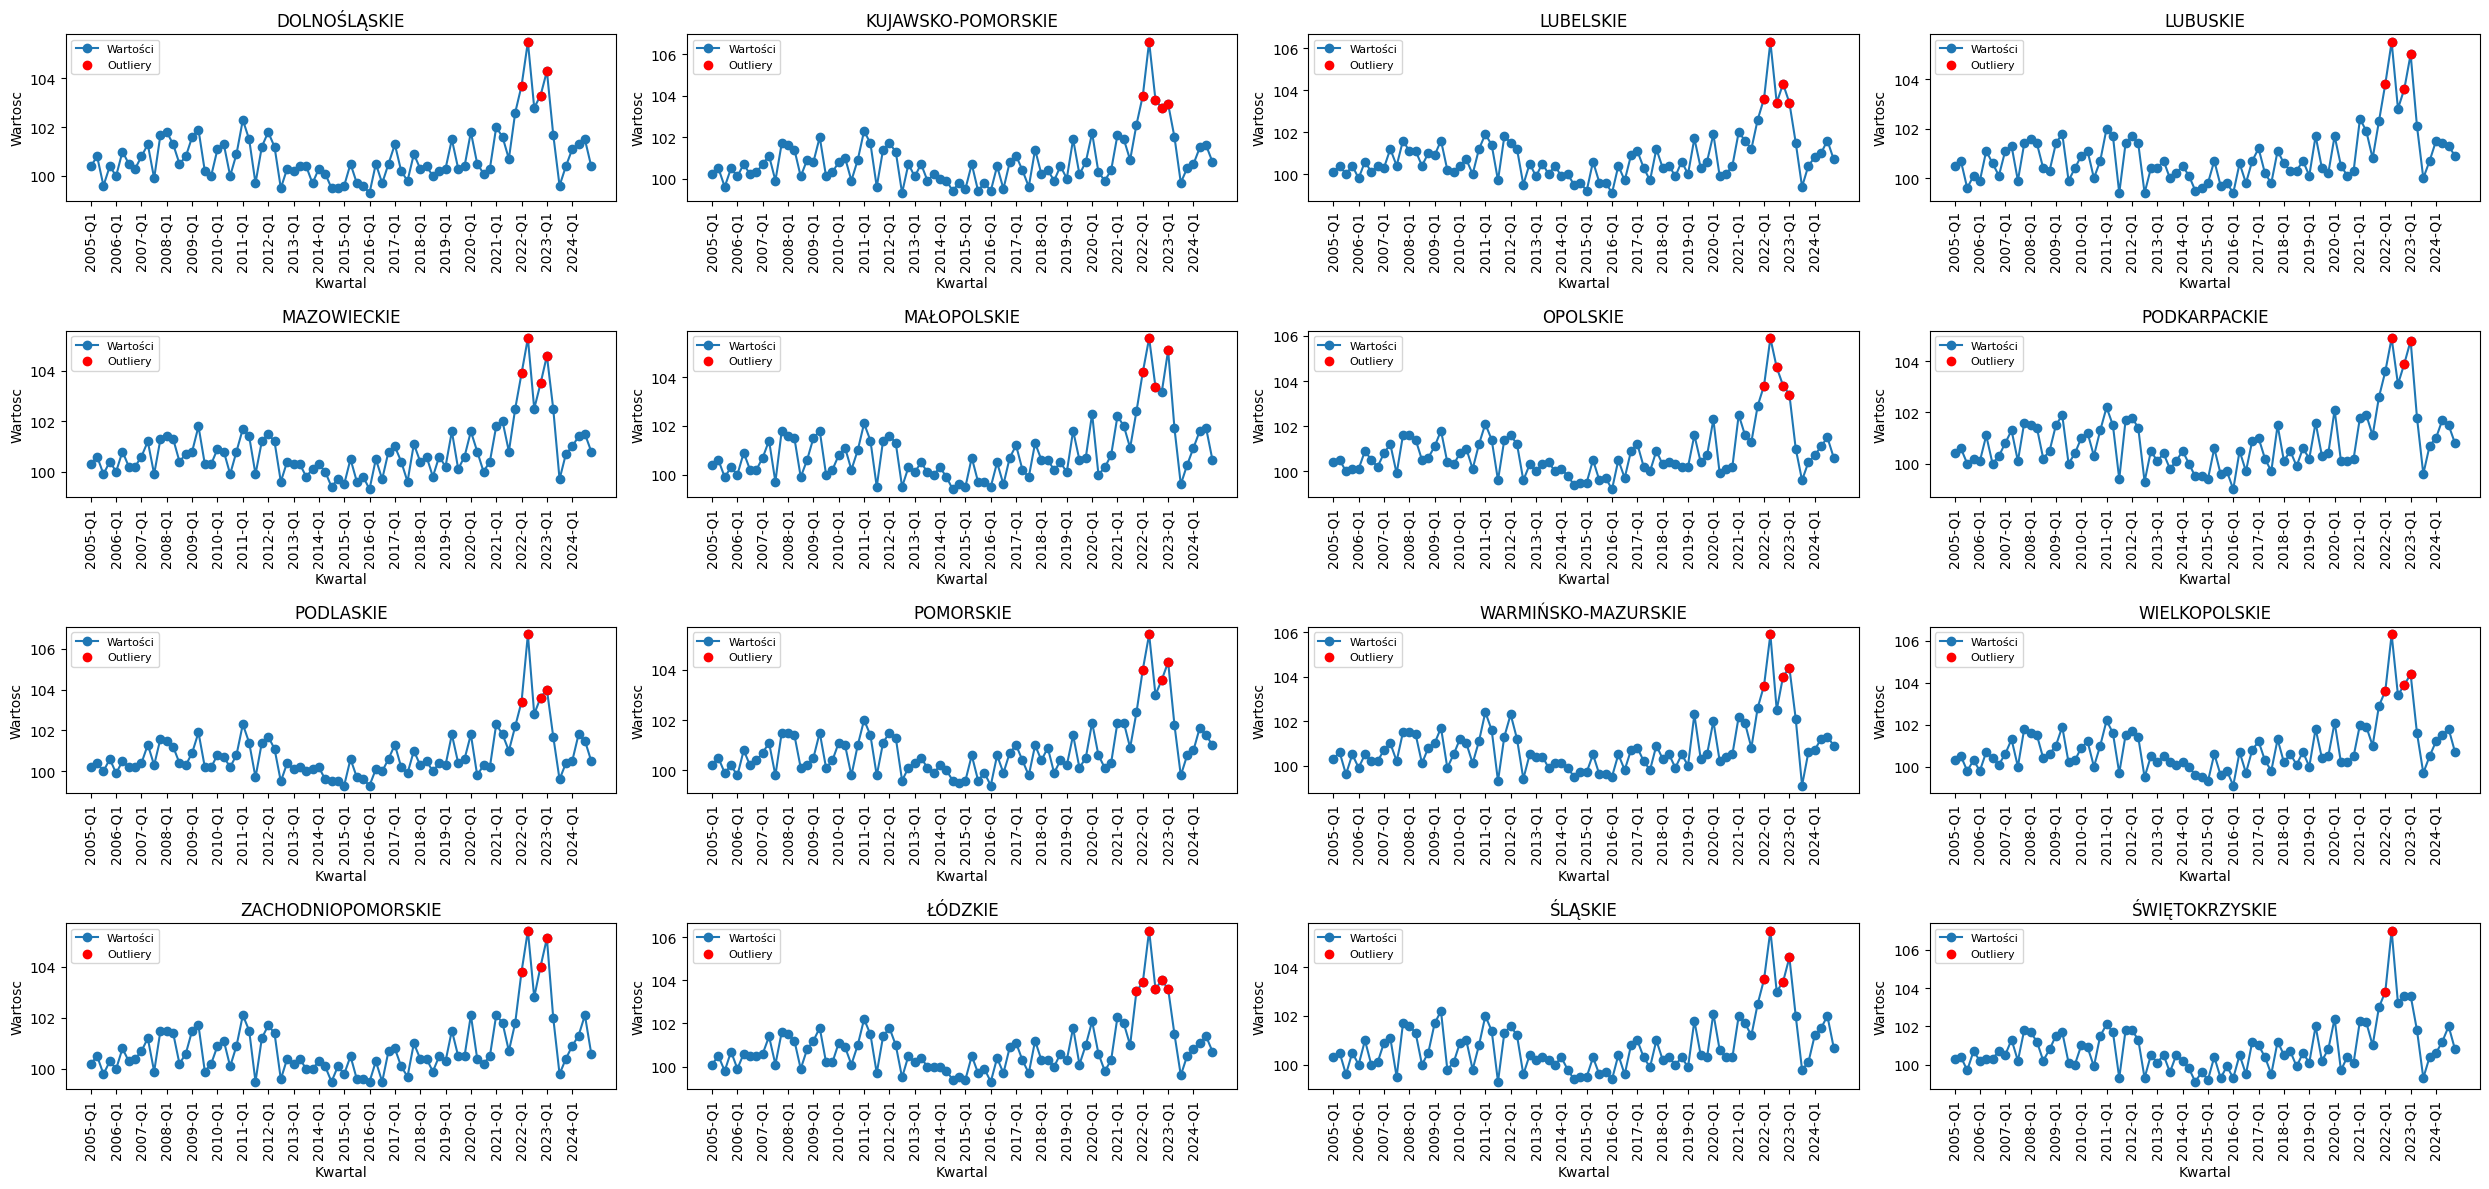

In [16]:
import warnings

def find_outliers(group):
    q1 = group['Wartosc'].quantile(0.25)
    q3 = group['Wartosc'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = group[(group['Wartosc'] < lower) | (group['Wartosc'] > upper)]
    return outliers

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    outliers_df = df.groupby('Wojewodztwo', group_keys=False).apply(find_outliers).reset_index()

wojewodztwa = df['Wojewodztwo'].unique()
n = len(wojewodztwa)
cols = 4
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(25, 12), sharex=False)
axes = axes.flatten()

for i, woj in enumerate(wojewodztwa):
    woj_df = df[df['Wojewodztwo'] == woj]
    woj_out = outliers_df[outliers_df['Wojewodztwo'] == woj]
    ax = axes[i]
    ax.plot(woj_df['Kwartal'], woj_df['Wartosc'], marker='o', label='Wartości')
    ax.scatter(woj_out['Kwartal'], woj_out['Wartosc'], color='red', label='Outliery', zorder=5)
    ax.set_title(woj)
    ax.set_xlabel('Kwartal')
    ax.set_ylabel('Wartosc')
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::4])
    ax.tick_params(axis='x', rotation=90)
    ax.legend(fontsize=8)

# Ukryj puste osie
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

*Wizualizacja: Wartości odstające inflacji w poszczególnych województwach.*

---

#### Wykres: Średnia inflacja w poszczególnych kwartałach

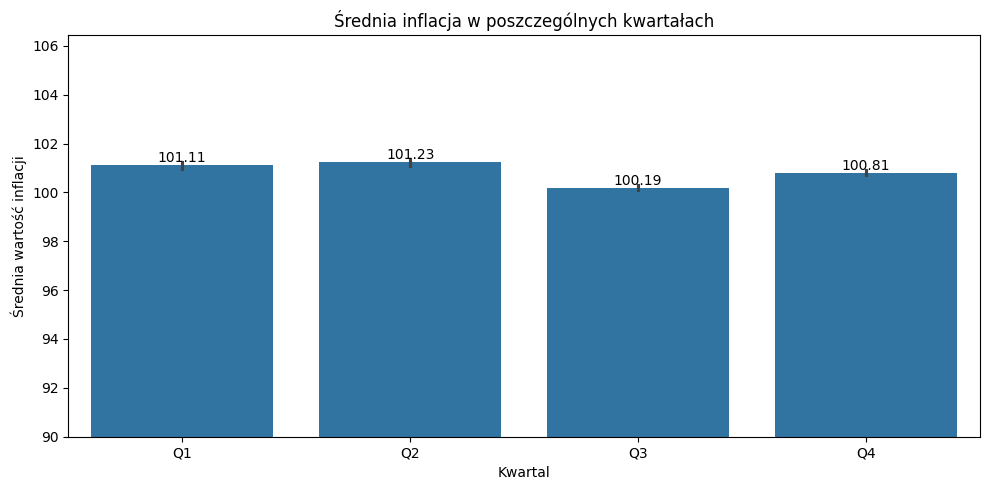

In [7]:
# Wykres: Średnia inflacja wg kwartału
plt.figure(figsize=(10,5))
sns.barplot(data=df, x='Okres', y='Wartosc')
plt.title('Średnia inflacja w poszczególnych kwartałach')
plt.ylim(90, None)
plt.xlabel('Kwartal')
plt.ylabel('Średnia wartość inflacji')
plt.tight_layout()
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom', fontsize=10, color='black', rotation=0)
plt.show()

*Wizualizacja: Sezonowość inflacji – najwyższe wartości na początku roku.*

---

### Prognozowanie inflacji

In [8]:
import warnings

wojewodztwa = df['Wojewodztwo'].unique()
results = []

for woj in wojewodztwa:
    df_woj = df[df['Wojewodztwo'] == woj].sort_values('Okres_czas').set_index('Okres_czas')
    train = df_woj[df_woj.index <= pd.Period('2022Q4')]
    test = df_woj[df_woj.index >= pd.Period('2023Q1')]

    # auto_arima
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        stepwise_model = auto_arima(train['Wartosc'], seasonal=True, m=4, suppress_warnings=True)
    model = ARIMA(train['Wartosc'], order=stepwise_model.order, seasonal_order=stepwise_model.seasonal_order)
    model_fit = model.fit(method_kwargs={"maxiter": 200})

    # prognoza na okres testowy
    forecast = model_fit.forecast(steps=len(test))
    forecast.index = test.index

    # błędy
    mae = mean_absolute_error(test['Wartosc'], forecast)
    rmse = np.sqrt(np.mean((test['Wartosc'] - forecast) ** 2))

    # prognoza na kolejne 4 kwartały
    future_forecast = model_fit.forecast(steps=4)

    results.append({
        'Wojewodztwo': woj,
        'MAE': mae,
        'RMSE': rmse,
        'Prognoza_nast_Q1': future_forecast.iloc[0],
        'Prognoza_nast_Q2': future_forecast.iloc[1],
        'Prognoza_nast_Q3': future_forecast.iloc[2],
        'Prognoza_nast_Q4': future_forecast.iloc[3],
    })

results_df = pd.DataFrame(results).sort_values(by='Wojewodztwo').reset_index(drop=True)
results_df

Wojewodztwo       MAE      RMSE  Prognoza_nast_Q1  \
0          DOLNOŚLĄSKIE  1.057990  1.349998        103.042604   
1    KUJAWSKO-POMORSKIE  1.798216  2.109858        104.257795   
2             LUBELSKIE  1.842612  2.201423        104.028267   
3              LUBUSKIE  2.630262  2.835831        105.125033   
4           MAZOWIECKIE  2.210909  2.382601        104.222372   
5           MAŁOPOLSKIE  3.100145  3.327341        104.639357   
6              OPOLSKIE  1.273130  1.776170        103.269950   
7          PODKARPACKIE  1.662043  1.895028        103.983461   
8             PODLASKIE  1.833321  2.130977        103.564815   
9             POMORSKIE  2.744541  2.935636        104.558241   
10  WARMIŃSKO-MAZURSKIE  2.276361  2.514340        104.126611   
11        WIELKOPOLSKIE  1.977402  2.313830        104.174993   
12   ZACHODNIOPOMORSKIE  2.142560  2.486010        105.092549   
13              ŁÓDZKIE  2.655085  2.851156        104.215455   
14              ŚLĄSKIE  1.665346  1.921836        103.719610   
15       ŚWIĘTOKRZYSKIE  1.768887  2.151510        103.898081   

    Prognoza_nast_Q2  Prognoza_nast_Q3  Prognoza_nast_Q4  
0         103.757840        102.228181        101.504872  
1         105.056674        103.667468        102.565568  
2         104.910522        103.169437        103.041379  
3         105.438958        103.761610        103.909744  
4         104.959720        102.875522        103.412013  
5         105.285196        104.173087        104.198731  
6         103.902339        103.216132        101.984858  
7         103.965890        103.159991        102.937568  
8         104.852343        103.016065        102.920822  
9         104.976134        103.594970        103.833097  
10        104.820131        103.339697        103.488421  
11        105.092403        103.631222        103.081806  
12        104.985644        103.634001        103.869870  
13        105.243038        103.612173        103.650360  
14        104.362231        103.072617        102.792637  
15        104.899030        103.249998        102.580991

*Wyniki: Tabela z prognozami inflacji oraz wskaźnikami jakości prognoz (MAE, RMSE) dla każdego województwa.*

---

#### Wykres: Porównanie błędów prognoz MAE i RMSE

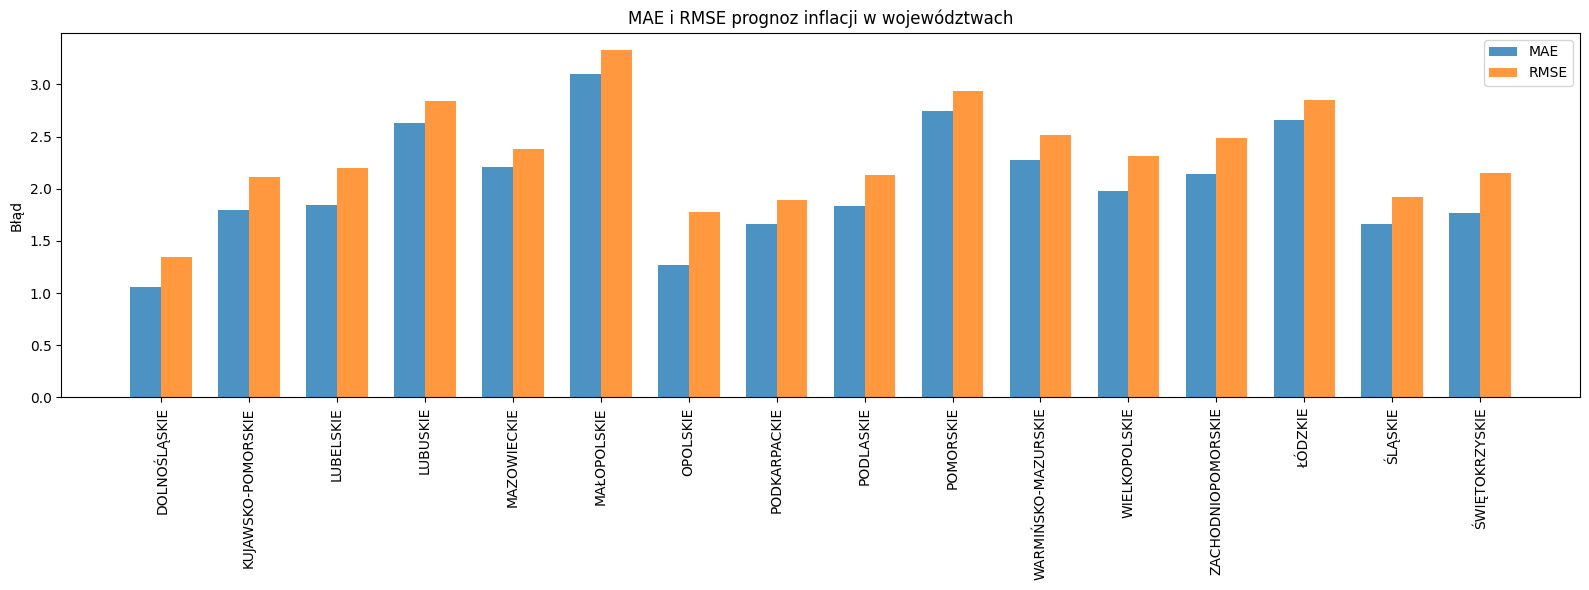

In [10]:
labels = results_df['Wojewodztwo']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(16,6))
rects1 = ax.bar(x - width/2, results_df['MAE'], width, label='MAE', alpha=0.8)
rects2 = ax.bar(x + width/2, results_df['RMSE'], width, label='RMSE', alpha=0.8)

ax.set_ylabel('Błąd')
ax.set_title('MAE i RMSE prognoz inflacji w województwach')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

*Wizualizacja: Poziom błędów prognoz w regionach.*

---

#### Wykres: Heatmapa prognozowanych wzrostów inflacji w kolejnych kwartałach

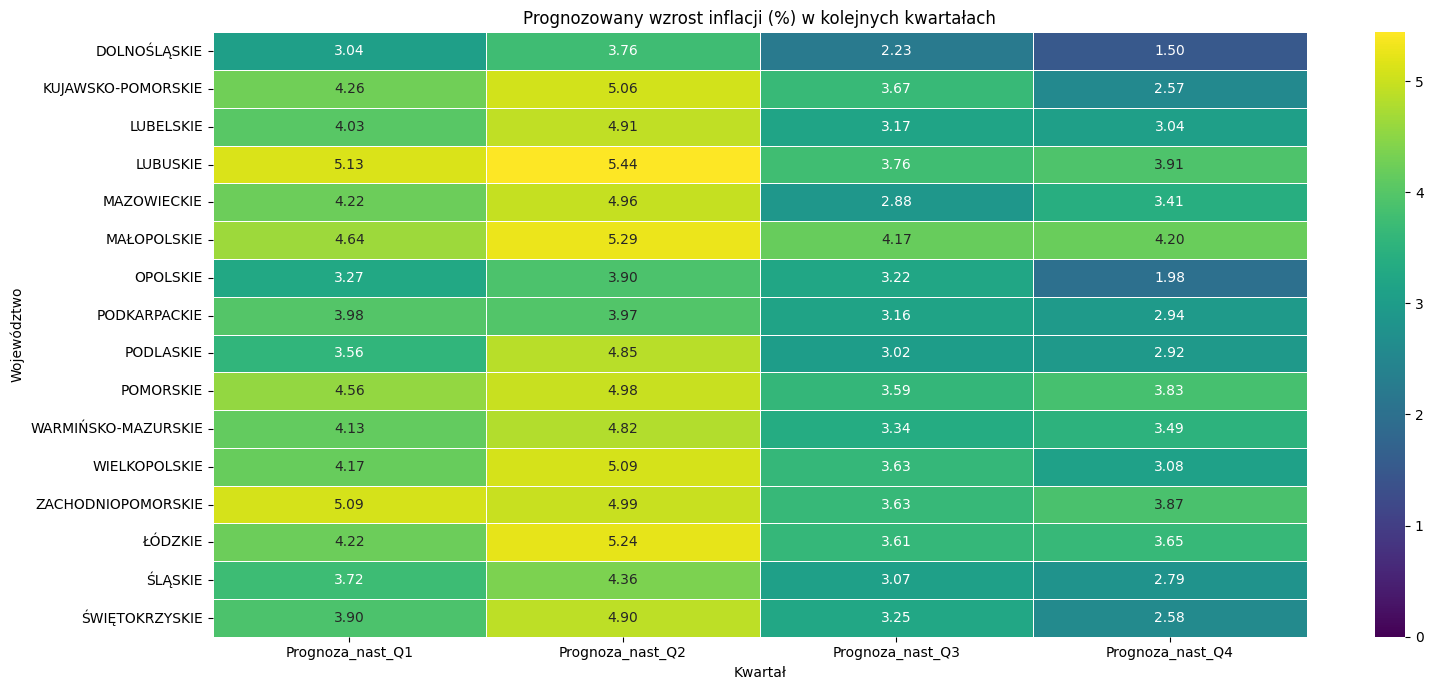

In [17]:
results_df_heatmap = results_df
future_cols = ['Prognoza_nast_Q1', 'Prognoza_nast_Q2', 'Prognoza_nast_Q3', 'Prognoza_nast_Q4']

if results_df_heatmap[future_cols[0]][0] > 100:
    for col in future_cols:
        results_df_heatmap[col] = results_df_heatmap[col] - 100

plt.figure(figsize=(16,7))
sns.heatmap(
    results_df_heatmap.set_index('Wojewodztwo')[future_cols],
    annot=True,
    cmap='viridis',
    vmin=0,
    fmt=".2f",
    linewidths=0.5,
    linecolor='white'
)
plt.title('Prognozowany wzrost inflacji (%) w kolejnych kwartałach')
plt.ylabel('Województwo')
plt.xlabel('Kwartał')
plt.tight_layout()
plt.show()

*Heatmapa: Prognozowane różnice inflacji w regionach w kolejnych kwartałach.*

---

### Wizualizacja prognoz na mapie Polski

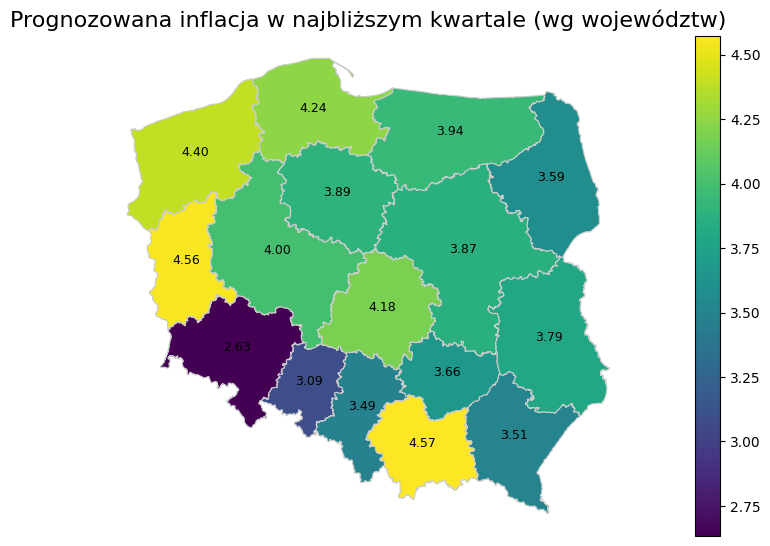

In [22]:
# Wczytaj plik geojson z granicami województw
gdf = gpd.read_file('wojewodztwa.geojson')

# Mapowanie nazw województw
mapping = {
    'dolnośląskie': 'DOLNOŚLĄSKIE',
    'kujawsko-pomorskie': 'KUJAWSKO-POMORSKIE',
    'lubelskie': 'LUBELSKIE',
    'lubuskie': 'LUBUSKIE',
    'mazowieckie': 'MAZOWIECKIE',
    'małopolskie': 'MAŁOPOLSKIE',
    'opolskie': 'OPOLSKIE',
    'podkarpackie': 'PODKARPACKIE',
    'podlaskie': 'PODLASKIE',
    'pomorskie': 'POMORSKIE',
    'warmińsko-mazurskie': 'WARMIŃSKO-MAZURSKIE',
    'wielkopolskie': 'WIELKOPOLSKIE',
    'zachodniopomorskie': 'ZACHODNIOPOMORSKIE',
    'łódzkie': 'ŁÓDZKIE',
    'śląskie': 'ŚLĄSKIE',
    'świętokrzyskie': 'ŚWIĘTOKRZYSKIE'
}
gdf['Wojewodztwo'] = gdf['nazwa'].map(mapping)

# Połącz dane z prognozą z geometrią województw
map_df = gdf.merge(results_df, on='Wojewodztwo')
map_df['Prognoza'] = map_df[['Prognoza_nast_Q1', 'Prognoza_nast_Q2', 'Prognoza_nast_Q3', 'Prognoza_nast_Q4']].mean(axis=1)

# Wizualizacja
fig, ax = plt.subplots(1, 1, figsize=(16, 6.5))
map_df.plot(column='Prognoza', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Prognozowana inflacja w najbliższym kwartale (wg województw)', fontdict={'fontsize':16})
ax.axis('off')

# Etykiety
for idx, row in map_df.iterrows():
    plt.annotate(f"{row['Prognoza']:.2f}",
                 xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=9)
plt.show()


*Mapa: Prognozowane średnie wartości inflacji w nadchodzących kwartałach.*

---

## 4. Wyniki obliczeń

- Dane obejmujące lata 2005–2024 wykazują umiarkowaną zmienność wskaźnika inflacji w skali kraju i regionów, a także delikatną sezonowość kwartalną (najwyższe wartości na początku roku).
- W analizowanym okresie wyraźny wzrost inflacji (lata 2021–2023) był związany z globalnymi zjawiskami gospodarczymi (np. pandemia COVID-19), co odnotowano we wszystkich województwach.
- Najtrafniejsze prognozy (najniższe MAE i RMSE) uzyskano dla województw o stabilniejszym przebiegu inflacji (dolnośląskie, opolskie, podkarpackie, śląskie).
- Największą prognozowaną dynamikę inflacji w najbliższych czterech kwartałach odnotowano w województwach lubuskim, pomorskim, łódzkim oraz kujawsko-pomorskim.
- Wyniki prognoz potwierdzają, że inflacja w Polsce ma w dużej mierze charakter ogólnokrajowy, a różnice regionalne są stosunkowo niewielkie.

---

## Podsumowanie i wnioski

Przeprowadzona analiza umożliwiła szczegółowe zbadanie dynamiki inflacji w polskich województwach w latach 2005–2024 oraz opracowanie wiarygodnych prognoz na kolejne kwartały. Dane wykazały umiarkowaną zmienność i sezonowość wskaźnika inflacji, a także silny wpływ czynników ogólnokrajowych na przebieg procesów inflacyjnych. Modele ARIMA pozwoliły uzyskać dobrej jakości prognozy dla większości regionów. Wizualizacja wyników na mapie Polski ułatwia intuicyjne porównanie sytuacji w poszczególnych województwach.

Należy pamiętać, że prognozy opierają się na założeniu kontynuacji dotychczasowych trendów i nie uwzględniają potencjalnych, nieprzewidywalnych zdarzeń przyszłych. W przyszłych badaniach warto rozważyć uwzględnienie dodatkowych zmiennych makroekonomicznych oraz alternatywnych metod prognostycznych dla jeszcze lepszego odwzorowania procesów inflacyjnych w Polsce.